In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import distinctipy
from scipy.interpolate import interp1d, UnivariateSpline
import glob,os
import matplotlib.colors as colors
import quaternion as quat
import matplotlib
from scipy.optimize import curve_fit

import numpy as np
%matplotlib inline

COLOR = 'k'#'#FFFAF1'
plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['xtick.major.size']  = 14 #12
plt.rcParams['ytick.major.size']  = 14#12

plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.size']  = 8
plt.rcParams['ytick.minor.size']  = 8

plt.rcParams['axes.linewidth'] = 3

plt.rcParams['text.color'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
#plt.rcParams['axes.spines.top'] = False
#plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['legend.facecolor'] = 'none'

figaspectratio = 1.2

peri=2458013

In [2]:
belton=pd.read_csv("../Lightcurves/Photometry/1I_2017U1_lightcurve.csv")

beltime=belton['corrMMJD'].to_numpy()+2458000.5-peri
belmag=belton['corrm'].to_numpy()
belsig=belton['sigma'].to_numpy()

belton=np.array([beltime,belmag,belsig]).T

octbeltime=beltime[beltime<60]
octbelmag=belmag[beltime<60]
octbelsig=belsig[beltime<60]

novbeltime=beltime[beltime>60]
novbelmag=belmag[beltime>60]
novbelsig=belsig[beltime>60]

In [3]:
def evolving_axis_lightcurve(theta,phi,psi,a,b,c,alpha,beta,sun=[1,0,0]): 
    import warnings
    warnings.filterwarnings("ignore")
    
    if isinstance(theta, (np.floating, float)): theta=[theta]
    if isinstance(phi, (np.floating, float)): phi=[phi]
    if isinstance(psi, (np.floating, float)): psi=[psi]
    
    if len(beta.shape)==1:
        alpha=alpha[None,:]
        beta=beta[None,:]
        
    if isinstance(a,(np.floating,float,int)): a=a*np.ones_like(beta)
    else: a=a[None,:]

    if isinstance(b,(np.floating,float,int)): b=b*np.ones_like(beta)
    else: b=b[None,:]

    if isinstance(c,(np.floating,float,int)): c=c*np.ones_like(beta)
    else: c=c[None,:]
    
    sun=quat.from_vector_part(sun)
    
    rot=np.array([np.cos(phi),np.sin(phi)*np.cos(psi),np.sin(phi)*np.sin(psi)]).T
    rot=np.einsum('ijk,ij->ijk',rot[:,None,:],beta)
    rot=quat.from_rotation_vector(rot)
    
    THETA,ALPHA=np.meshgrid(theta,alpha,indexing='ij')
    
    obs=np.array([np.cos(ALPHA),np.sin(ALPHA)*np.cos(THETA),np.sin(ALPHA)*np.sin(THETA)])
    obs=np.einsum('ijk->jki',obs)
    
    obs=quat.from_vector_part(obs)
    obs=quat.as_vector_part(rot*obs*rot.conj())
    
    sun=quat.as_vector_part(rot*sun*rot.conj())
    
    C=np.einsum('ijk->jki',np.array([1/a**2,1/b**2,1/c**2]))
    Ts=np.sqrt(np.einsum('ijk,ijk,ijk->ij',sun,sun,C))
    To=np.sqrt(np.einsum('ijk,ijk,ijk->ij',obs,obs,C))

    cosa=np.einsum('ijk,ijk,ijk->ij',sun,obs,C)/(Ts*To)
    cosa[np.where(cosa>1)]=1
    cosa[np.where(cosa<-1)]=-1
    
    aprime=np.arccos(cosa)
    
    aprime[np.isclose(aprime,0)]=0
    
    T=np.sqrt(np.abs(Ts**2+To**2+2*Ts*To*cosa))
    
    cosl=np.nan_to_num((Ts+To*cosa)/T,posinf=0,neginf=0)
    sinl=np.nan_to_num((To*np.sin(aprime))/T,posinf=0,neginf=0)

    lam=np.where(sinl>=0,np.arccos(cosl),-np.arccos(cosl)%(2*np.pi))
    lam[np.isclose(lam,0,atol=1e-6)]=0
    
    cotl=1/np.tan(lam/2)
    cotal=1/np.tan((aprime-lam)/2)
    
    L = np.where(np.sin(lam)!=0,sinl*np.sin(lam-aprime)*np.log(cotl*cotal),0)
    L += cosl+np.cos(lam-aprime)
    L[np.isclose(L,0)]=0
    L[L!=0] *= (np.pi*a*b*c*Ts*To/T)[L!=0]
    L[L==0] = 1e-15
    return(np.abs(L))

def magvalues(time,args,theta,phi,psi,betai,deltaV):
    p,a,b,c,alpha=args
    p=p/24
    beta=2*np.pi*((time)%p)/p-betai
    curve=deltaV-2.5*np.log10(evolving_axis_lightcurve(theta,phi,psi,a,b,c,alpha,beta))
    return(curve[0,:])

def chi2(x,y,sy):
    return(np.sum(np.square(x-y)/sy**2))


In [4]:
# Get sizes and periods from simulations

sizes=[35,55,75,95,115,150]
pinit=7.40

adict={}
bdict={}
cdict={}
perdict={}

tmaxdict={}

for i,s in enumerate(sizes):
    sadict={}
    sbdict={}
    scdict={}
    spdict={}
    stdict={}
    for file in glob.glob("../Simulations/logs/*pancake_*a"+str(s)+"*.csv"):  
        mu=int(file.split("_")[-1][:-4])
            
        pancake=pd.read_csv(file,names=['Times',"MoIs","a","b","c"]).drop(np.nan,axis=0)
        times=pancake['Times'].to_numpy(dtype=float)/86400-2458000.5
        times=pancake['Times'].to_numpy(dtype=float)/86400-peri
        
        a=pancake['a'].to_numpy(dtype=float)/50
        b=pancake['b'].to_numpy(dtype=float)/50
        c=pancake['c'].to_numpy(dtype=float)/50
        
        axarray=np.sort(np.array([a,b,c]),axis=0)
        
        moi=pancake['MoIs'].to_numpy(dtype=float)
        
        per=pinit*moi/moi[0]
        
        sadict[mu]=(UnivariateSpline(times,axarray[2,:]))
        sbdict[mu]=(UnivariateSpline(times,axarray[1,:]))
        scdict[mu]=(UnivariateSpline(times,axarray[0,:]))
        spdict[mu]=(UnivariateSpline(times,per))
        
        stdict[mu]=(np.max(times))
        
    adict[s]=sadict
    bdict[s]=sbdict
    cdict[s]=scdict
    perdict[s]=spdict
    tmaxdict[s]=stdict

In [5]:
phase=pd.read_csv("../Lightcurves/Photometry/PhaseData.csv")
MJD=phase['MJD'].to_numpy()+2458000.5-peri
datalpha=phase['Phase'].to_numpy()*np.pi/180

alpha=interp1d(MJD,datalpha,'linear')

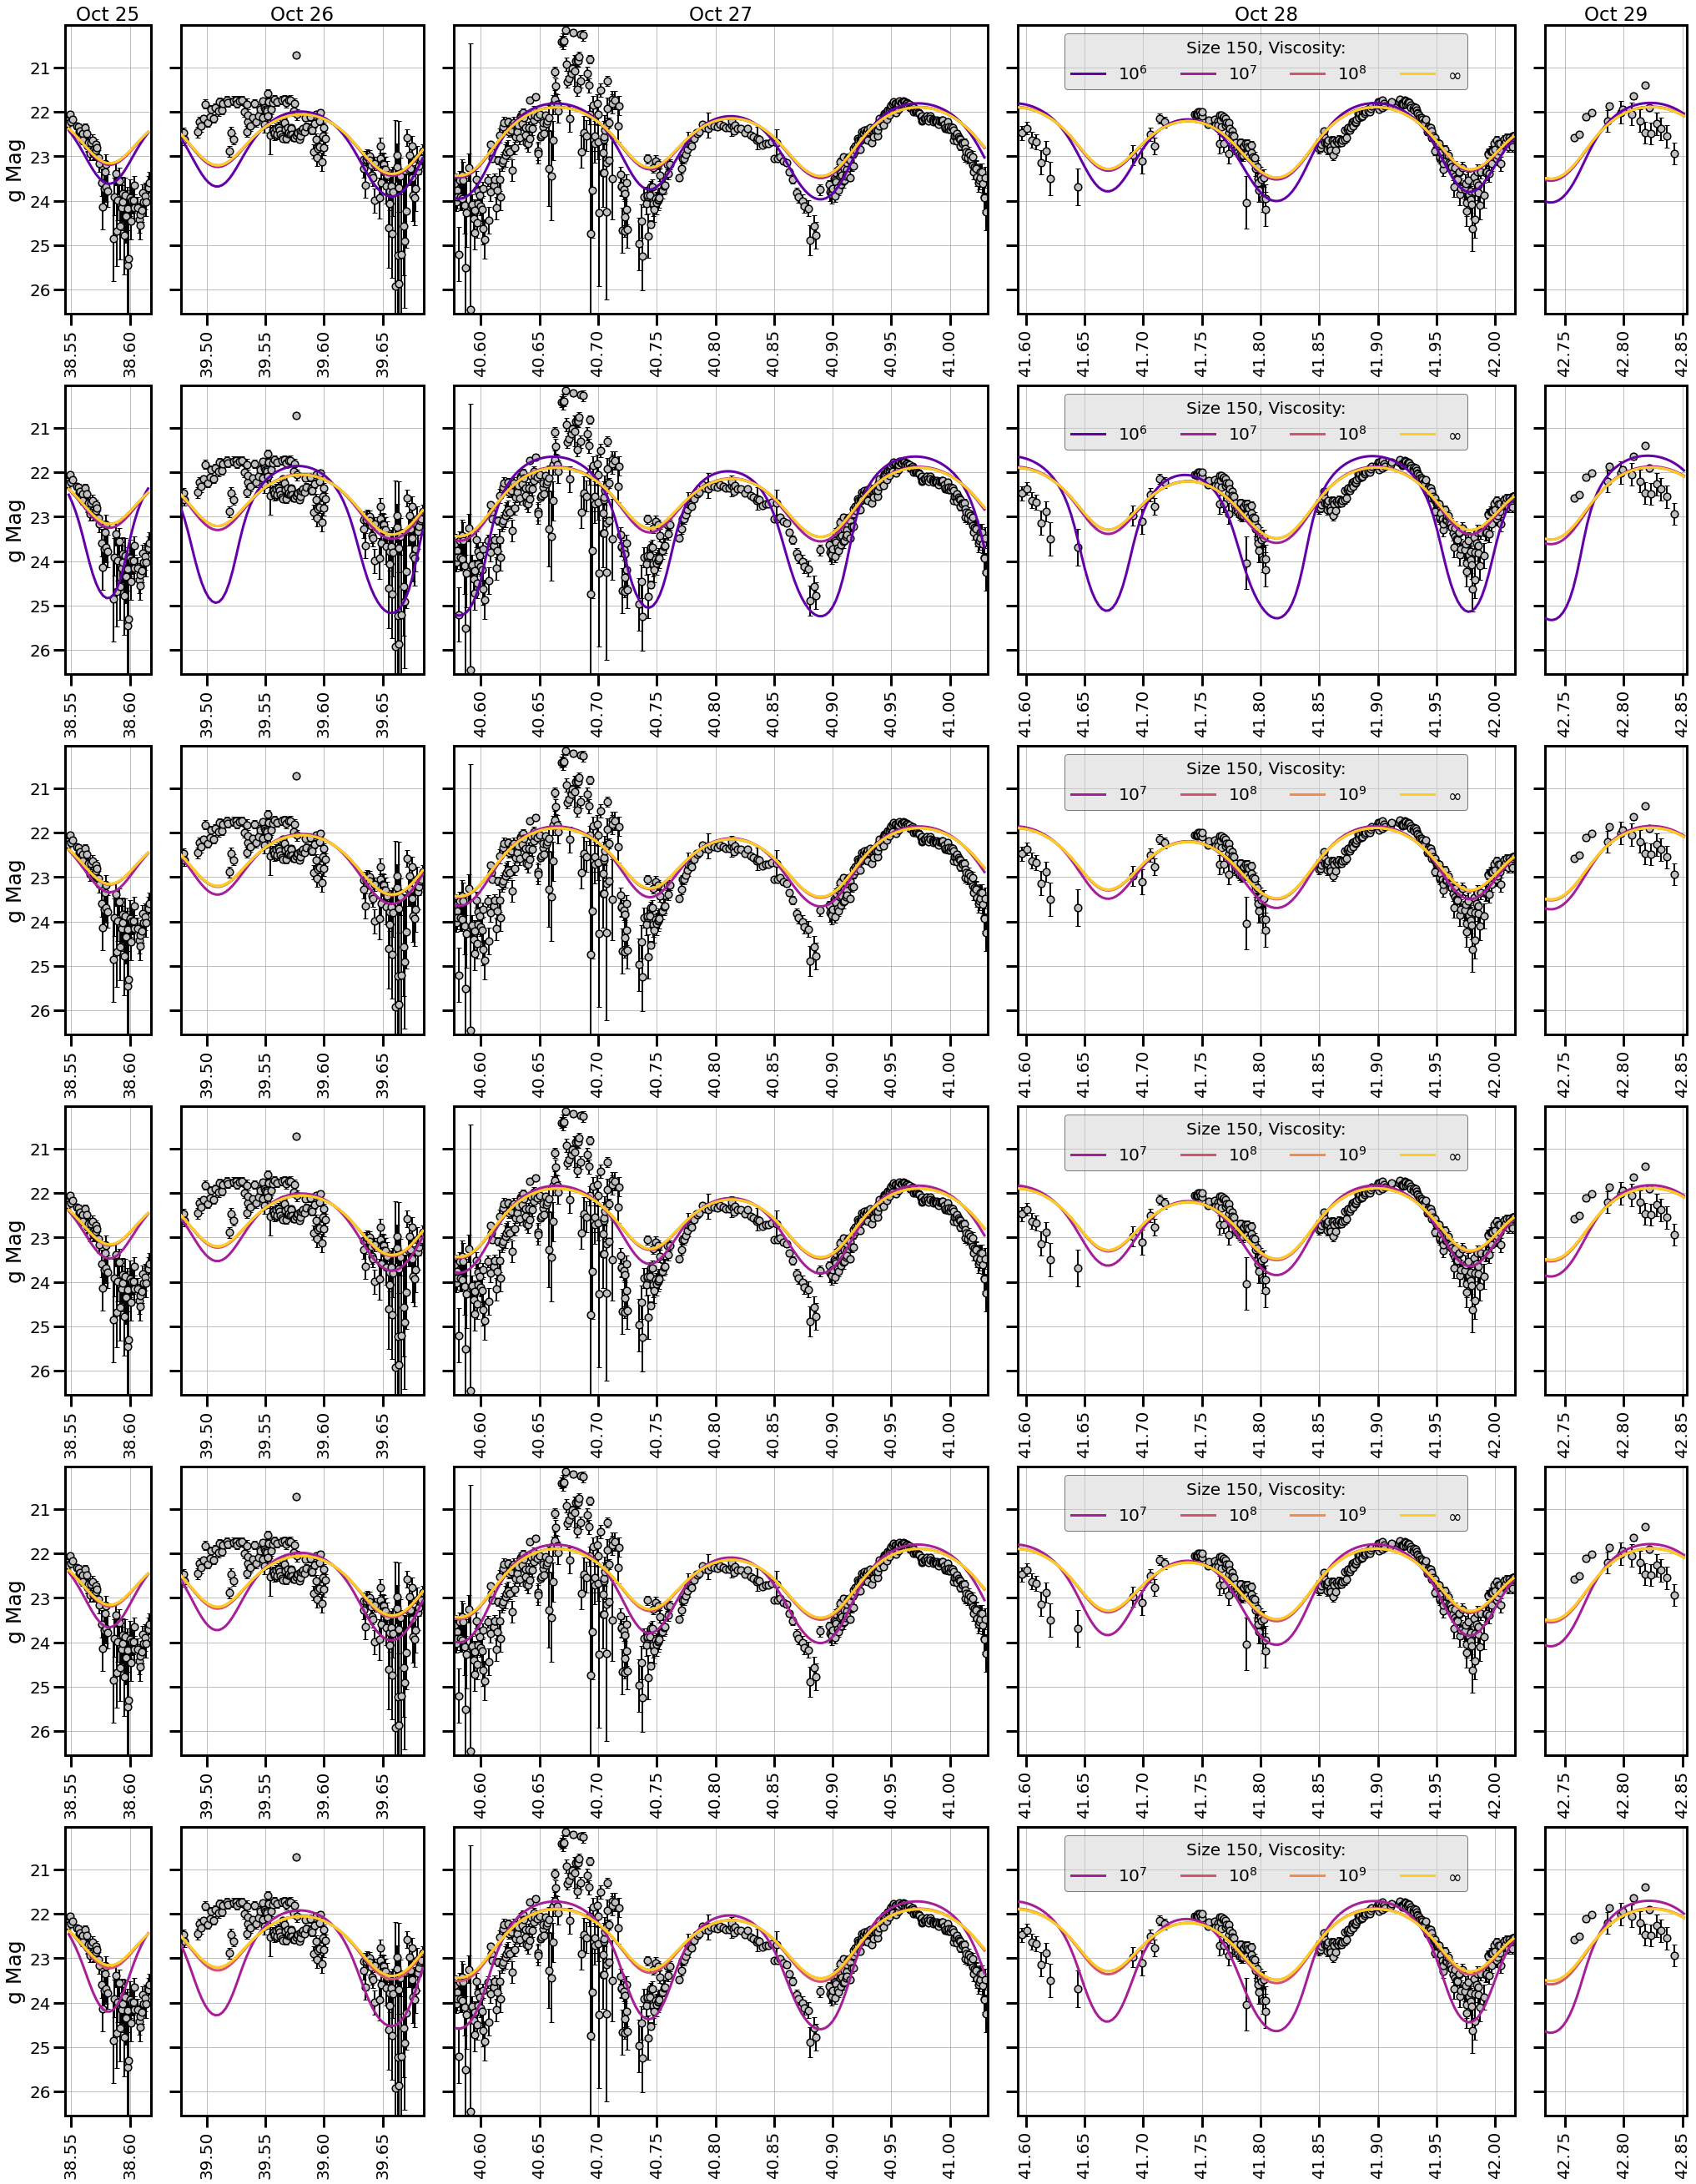

In [6]:
optparams=[4.75924567, 1.42272942, 1.24770105, 4.35406442, 32.18076141]

cols=['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#984ea3']

cmap=matplotlib.cm.get_cmap('plasma')
cols=cmap(np.linspace(0,.9,6))

import matplotlib.ticker as ticker

figx=25
figy=figx*figaspectratio

fig = plt.figure(figsize=(figx,figy))
ymin,ymax=np.min(belton[:,1])-0.1,np.max(belton[:,1])+0.1

labels=['Oct 25','Oct 26','Oct 27','Oct 28','Oct 29','Oct 30','Nov 21','Nov 22','Nov 23']
days=np.unique((beltime+.75)//1)-.75

limits=[]
for d in days:
    xmin=np.min(beltime[((beltime+.75)//1-.75)==d])
    xmax=np.max(beltime[((beltime+.75)//1-.75)==d])
    if (xmax-xmin)<0.05:
        xmin-=0.02
        xmax+=0.02
    limits.append((xmin,xmax))

axspace=0.02
tickspace=0.05

yspace=0.04

toprow=5
totalwidth=0
for i in range(5):
    totalwidth+=limits[i][1]-limits[i][0]
platescale=1/totalwidth

corner=0

sizes=[35,55,75,95,115,150]
p=7.4008
times=np.linspace(np.min(beltime),np.max(beltime)+0.1,10000)

axes=[]
for i in range(30):
    sz=sizes[i//5]
    xmin,xmax=limits[i%5]
    dx = (xmax-xmin)*platescale
    ax=fig.add_axes([corner,(4-i//5)*(1/5),dx,1/5-yspace])
    axes.append(ax)
    ax.set_xlim([xmin,xmax])
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tickspace))
    if i//5 == 0: ax.set_title(labels[i%5],fontsize=23)
    for mu in perdict[sz].keys():
        #handles.append(plt.Line2D([0,1],[0,1],color=cols[mu-5],linewidth=5,label='$10^{%s}$'%mu))
        if np.max(times)<=tmaxdict[sz][mu]:
            optwrapper=lambda time,betai,deltaV: magvalues(time-np.min(time),
                                                (p,adict[sz][mu](time),bdict[sz][mu](time),
                                                 cdict[sz][mu](time),alpha(time)),*optparams[:3],betai,deltaV)
            octopt,_=curve_fit(optwrapper,octbeltime,octbelmag,p0=optparams[3:],
                    sigma=octbelsig,absolute_sigma=False,
                    bounds=([0,20],[2*np.pi,40]),maxfev=5000)
            curve=magvalues(times-np.min(times),
                                       (p,adict[sz][mu](times),bdict[sz][mu](times),
                                        cdict[sz][mu](times),alpha(times)),*optparams[:3],*octopt)
            ax.plot(times[np.where((times<xmax)&(times>xmin))],
                     curve[np.where((times<xmax)&(times>xmin))],
                     color=cols[mu-5],label=r"$10^{%s}$"%mu,zorder=3,lw=3)
        
     # plot with no modificiation
    octopt,_=curve_fit(optwrapper,octbeltime,octbelmag,p0=optparams[3:],
            sigma=octbelsig,absolute_sigma=False,
            bounds=([0,20],[2*np.pi,40]),maxfev=5000)
    curve=magvalues(times-np.min(times),
                               (p,adict[sz][mu](times),bdict[sz][mu](times),
                                cdict[sz][mu](times),alpha(times)),*optparams[:3],*octopt)
    ax.plot(times[np.where((times<xmax)&(times>xmin))],
             curve[np.where((times<xmax)&(times>xmin))],
             color=cols[-1],label=r"$\infty$",zorder=3,lw=3)

    ax.errorbar(belton[:,0][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
                  belton[:,1][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
                  yerr=belton[:,2][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))], 
                  fmt='none',ecolor='k',elinewidth=2,capsize=3)
    ax.scatter(belton[:,0][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
                  belton[:,1][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
                  s=75,edgecolors='k', linewidths=1.5,marker='o',color='silver',zorder=2)
        
    plt.xticks(rotation=90)
    corner+=dx+axspace
    
    if i%5 == 0:
        ax.set_ylabel("g Mag", fontsize=25)
    else:
        ax.set_yticklabels([])
    if i%5 == 3: ax.legend(ncol=4,title='Size '+str(s)+', Viscosity:',
              fancybox=True,edgecolor='black',facecolor='lightgray',framealpha=0.5,loc='upper center')
    if i%5 == 4: corner=0

for ax in axes:
    ax.grid()
    ax.set_ylim([ymax,ymin])
    
fig.set_rasterized(True)

plt.savefig('../Figures and Paper/optimal_sims_lightcurve_comp.pdf',
           bbox_inches='tight',dpi=300)

In [8]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    
    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    return im, cbar


In [38]:
chi2arr=np.zeros((6,6))

poct=7.4008
pnov=7.2005

for i,sz in enumerate(sizes):
    for j,mu in enumerate(perdict[sz].keys()):
        if np.max(times)<=tmaxdict[sz][mu]:
            optwrapper=lambda time,betai,deltaV: magvalues(time-np.min(time),
                                                (p,adict[sz][mu](time),bdict[sz][mu](time),
                                                 cdict[sz][mu](time),alpha(time)),*optparams[:3],betai,deltaV)
            octopt,_=curve_fit(optwrapper,octbeltime,octbelmag,p0=optparams[3:],
                    sigma=octbelsig,absolute_sigma=False,
                    bounds=([0,20],[2*np.pi,40]),maxfev=5000)
            octcurve=magvalues(octbeltime-np.min(octbeltime),
                                       (poct,adict[sz][mu](octbeltime),bdict[sz][mu](octbeltime),
                                        cdict[sz][mu](octbeltime),alpha(octbeltime)),*optparams[:3],*octopt)
            chi2arr[i,j]+=chi2(octcurve,octbelmag,octbelsig)
            
            novopt,_=curve_fit(optwrapper,novbeltime,novbelmag,p0=optparams[3:],
                    sigma=novbelsig,absolute_sigma=False,
                    bounds=([0,20],[2*np.pi,40]),maxfev=5000)
            novcurve=magvalues(novbeltime-np.min(novbeltime),
                                       (pnov,adict[sz][mu](novbeltime),bdict[sz][mu](novbeltime),
                                        cdict[sz][mu](novbeltime),alpha(novbeltime)),*optparams[:3],*novopt)
            chi2arr[i,j]+=chi2(novcurve,novbelmag,novbelsig)
            
    octopt,_=curve_fit(optwrapper,octbeltime,octbelmag,p0=optparams[3:],
            sigma=octbelsig,absolute_sigma=False,
            bounds=([0,20],[2*np.pi,40]),maxfev=5000)
    octcurve=magvalues(octbeltime-np.min(octbeltime),
                       (poct,float(adict[sz][mu](0)),float(bdict[sz][mu](0)),
                        float(cdict[sz][mu](0)),alpha(octbeltime)),*optparams[:3],*octopt)
    chi2arr[i,-1]+=chi2(octcurve,octbelmag,octbelsig)

    novopt,_=curve_fit(optwrapper,novbeltime,novbelmag,p0=optparams[3:],
            sigma=novbelsig,absolute_sigma=False,
            bounds=([0,20],[2*np.pi,40]),maxfev=5000)
    novcurve=magvalues(novbeltime-np.min(novbeltime),
                      (pnov,float(adict[sz][mu](0)),float(bdict[sz][mu](0)),
                       float(cdict[sz][mu](0)),alpha(novbeltime)),*optparams[:3],*novopt)
    chi2arr[i,-1]+=chi2(novcurve,novbelmag,novbelsig)
    

chi2arr[chi2arr==0]=np.nan
            
with np.printoptions(formatter={'float': '{: 0.3e}'.format}):    
    print(chi2arr)

[[ nan  5.038e+04  3.882e+04  3.833e+04  nan  3.831e+04]
 [ nan  1.078e+05  3.981e+04  3.840e+04  nan  3.835e+04]
 [ nan  nan  4.175e+04  3.851e+04  3.830e+04  3.829e+04]
 [ nan  nan  4.539e+04  3.867e+04  3.832e+04  3.830e+04]
 [ nan  nan  5.217e+04  3.886e+04  3.833e+04  3.831e+04]
 [ nan  nan  8.213e+04  3.935e+04  3.837e+04  3.833e+04]]


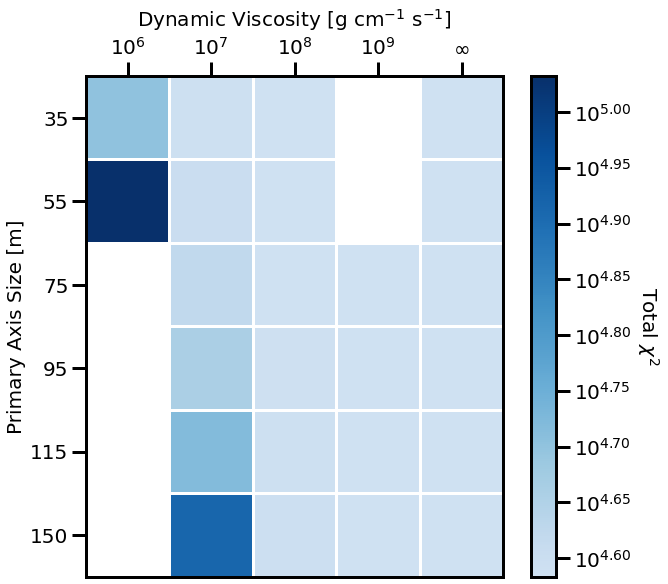

In [42]:
cmap = colors.LinearSegmentedColormap.from_list("test",plt.get_cmap('Blues')(np.linspace(0.2,1,100)))
cmap.set_bad('white')

fmt=matplotlib.ticker.FuncFormatter(lambda x,pos: np.where(x,'x',''))

fig,ax=plt.subplots(1,1,figsize=(10,8),sharex=True,sharey=False,constrained_layout=True)

labs=[r'$10^{{{}}}$'.format(elem) for elem in np.arange(6,10)]
labs.append(r"$\infty$")

def fmtbar(x,pos):
    return(r'$10^{{{x:.2f}}}$'.format(x=x))

im,cbar=heatmap(np.log10(chi2arr[:,1:]),row_labels=sizes,col_labels=labs,cbarlabel=r"Total $\chi^2$",cmap=cmap,
                cbar_kw={"format":ticker.FuncFormatter(fmtbar)})
ax.set_xlabel(r"Dynamic Viscosity [g cm$^{-1}$ s$^{-1}$]", labelpad=10)  
ax.xaxis.set_label_position('top') 
ax.set_ylabel("Primary Axis Size [m]")

fig.set_rasterized(True)

plt.savefig("../Figures and Paper/sim_chi2_heatmap.pdf",
           bbox_inches='tight',dpi=300)